### Loading packages

In [2]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

import theano
# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_kimnqlq3.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


### Loading surface points from repository:

With pandas we can do it directly from the web and with the right args we can directly tidy the data in gempy style:

In [3]:
Moureze_points = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Moureze/Moureze_Points.csv', sep=';',
                         names=['X', 'Y', 'Z', 'G_x', 'G_y', 'G_z', '_'], header=0, )
Sections_EW = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Moureze/Sections_EW.csv', sep=';',
                         names=['X', 'Y', 'Z', 'ID', '_'], header=1).dropna()
Sections_NS = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Moureze/Sections_NS.csv', sep=';',
                         names=['X', 'Y', 'Z', 'ID', '_'], header=1).dropna()

Extracting the orientatins:

In [4]:
mask_surfpoints = Moureze_points['G_x'] < -9999
surfpoints = Moureze_points[mask_surfpoints]
orientations = Moureze_points[~mask_surfpoints]

Giving an arbitrary value name to the surface

In [5]:
surfpoints['surface'] = 0.0
orientations['surface'] = 0.0

In [8]:
surfpoints.tail()

,X,Y,Z,G_x,G_y,G_z,_,surface
3425,177.428558,155.904465,-152.007,-99999.0,-99999.0,-99999.0,0.045217,0.0
3426,89.924927,86.352005,-120.026,-99999.0,-99999.0,-99999.0,0.067264,0.0
3427,75.935799,116.717010,-140.023,-99999.0,-99999.0,-99999.0,0.783988,0.0
3428,177.964096,233.829971,-148.831,-99999.0,-99999.0,-99999.0,0.523201,0.0
3429,46.487995,17.739241,-148.019,-99999.0,-99999.0,-99999.0,0.110549,0.0


In [9]:
orientations.tail()

,X,Y,Z,G_x,G_y,G_z,_,surface
3409,47.970890,129.885971,-132.010,-0.453523,-0.849487,0.269609,0.016933,0.0
3420,175.944580,293.731140,-138.019,0.217228,-0.884429,0.413035,0.444558,0.0
3421,203.969635,367.725098,-150.011,0.217373,-0.971044,-0.099104,0.708855,0.0
3422,133.925903,225.623962,-146.756,0.318182,-0.872684,-0.370381,0.126039,0.0
3430,290.000000,180.000000,-103.539,0.126294,-0.192654,0.973105,0.679096,0.0


### Data initialization:


Suggested size of the axis-aligned modeling box:

Origin: -5 -5 -200

Maximum: 305 405 -50

Suggested resolution: 2m (grid size 156 x 206 x 76)

### Only using one orientation because otherwhise it gets a mess

In [10]:
# Number voxels
np.array([156, 206, 76]).prod()

2442336

In [11]:
resolution_requ = [156, 206, 76]
resolution = [77, 103, 38]
geo_model = gp.create_model('Moureze')
geo_model = gp.init_data(geo_model, 
                         extent=[-5,305,-5,405,-200, -50], resolution=resolution_requ,
                         surface_points_df=surfpoints, orientations_df=orientations,
                         surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Now we can see how the data looks so far:

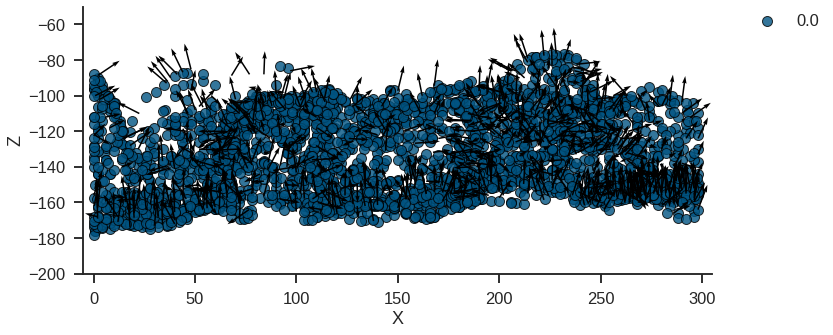

In [13]:
gp.plot.plot_data(geo_model, direction='y')

In [14]:
gp.set_interpolation_data(geo_model, 
                          theano_optimizer='fast_run')

Compiling theano function...
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  0
Compilation Done!


The default range is always the diagonal of the extent. Since in this model data is very close we will need to reduce the range to 5-10% of that value:

In [15]:
val=.1
geo_model.interpolator.theano_graph.a_T.set_value(val)
geo_model.interpolator.theano_graph.a_T_surface.set_value(val)


In [16]:
gp.compute_model(geo_model, set_solutions=True, sort_surfaces=False)


Lithology ids 
  [2. 2. 2. ... 1. 1. 1.] 

### Time
#### 300k voxels 3.5k points
- Nvidia 2080: 500 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each), Memory 1 Gb
- CPU  14.2 s ± 82.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each), Memory: 1.3 Gb

#### 2.4 M voxels, 3.5k points

- CPU 2min 33s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) Memory: 1.3 GB
- Nvidia 2080:  1.92 s ± 6.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 1 Gb

#### 2.4 M voxels, 3.5k points 3.5 k orientations
- Nvidia 2080: 2.53 s ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

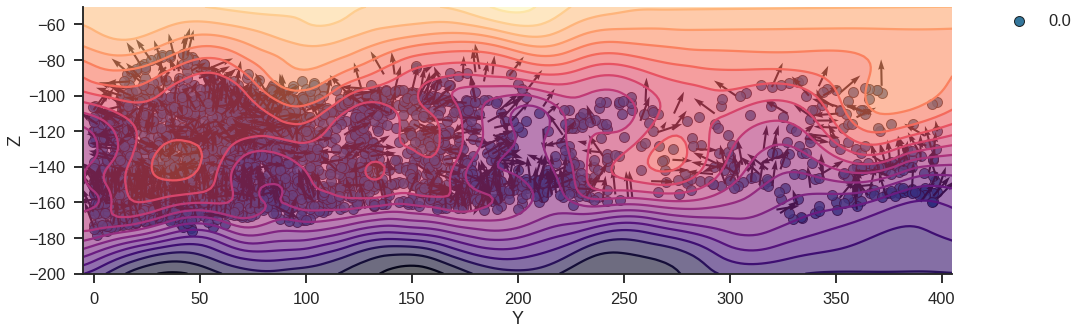

In [17]:
gp.plot.plot_scalar_field(geo_model, 16, series=0, direction='x')

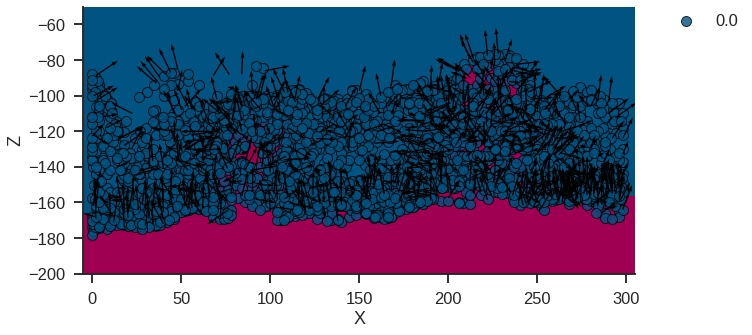

In [18]:
gp.plot.plot_section(geo_model,16, show_data=True, direction='y')

In [20]:
# gp.plot.plot_3D(geo_model, render_data=False)

closing vtk



![](./Moureze.png)